# Additional CNN experiments

In this notebook, we performed additional experiments with

* CNN architectures with dilated convolutions
* Adding a Gaussian noise layer
* Adding a skip connection with separately extracted time series features

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

from tensorflow import keras
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, Conv1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, BatchNormalization, Bidirectional, LSTM, Flatten, GaussianNoise, Add
from keras.models import load_model, Model, Sequential

from livelossplot import PlotLossesKeras 

import tsfel
from tsfel.feature_extraction.calc_features import calc_window_features

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from itertools import product

# custom modules
from utils import *
from cf_matrix import *
from model_parts import *
from data import get_tsfel_features

In [2]:
# !pip install livelossplot
# !pip install tsfel

In [2]:
%load_ext autoreload
%autoreload 2

## Set default parameters

In [3]:
# Training parameters
EPOCHS = 40
BATCH_SIZE = 32

# Hyperparameters
N_FILT = 32
KERNEL_SIZE = 11
SEQUENCE_LENGTH = 187
NO_CLASSES = 5
N_CHANNELS = 1

## CNN Architectures

In [4]:
def cnn_model(n1_cnn_layer = 3, n2_cnn_layer = 4, n3_dnn_layer = 2, 
              n_filt = N_FILT, kernel_size = KERNEL_SIZE, dropout_rate = 0.5,
              Gaussian_noise=False, stddev=None,
              skip_feats_dim = None):
    
    """
    Args:
        n1_cnn_layer: number of extra 1D-convolutional layers (with dilation_rate=1)
        n2_cnn_layer: number of 1D-convolutional layers with dilation_rate=4
        n3_dnn_layer: number of dense layers
        N_FILT:       number of filters
        KERNEL_SIZE:  size of kernels
        dropout_rate: Dropout rate during traing
        Gaussian noise (Bool): Add a Gaussian Noise layer if true
        skip_feats_dim: Dimension of separate features integrated via skip connection
        
    Output:
        CNN model with corresponding parametrization
    """
    
    heartbeats = Input(shape=(SEQUENCE_LENGTH, 1), name = "heartbeats")
    
    # Add input for skip connection
    if skip_feats_dim is not None:
        features = Input(shape=(skip_feats_dim), name="features")  
    
    # Add Gaussian layer for heartbeats
    if Gaussian_noise:
        assert stddev is not None
        signal = GaussianNoise(stddev=stddev)(heartbeats)
    else: 
        signal = heartbeats
    
    # add 1D-convolutional layers (with dilation_rate=1)
    conv = Conv1D(N_FILT, 1, dilation_rate=1, activation='relu', padding='causal')(signal) 
    for _ in range(n1_cnn_layer):
        conv = Conv1D(N_FILT, KERNEL_SIZE, dilation_rate=1, activation='relu', padding='causal')(conv)

    conv = Dropout(dropout_rate)(conv)
    conv = BatchNormalization()(conv)

    # add 1D-convolutional layers with dilation_rate=4
    for _ in range(n2_cnn_layer):
        conv = Conv1D(N_FILT, KERNEL_SIZE, dilation_rate=4, activation='relu', padding='causal')(conv)

    conv = Dropout(dropout_rate)(conv)
    conv = BatchNormalization()(conv)
    conv = Flatten()(conv)

    # concatenate skip connection
    if skip_feats_dim is not None:
        dense = concatenate([conv, features])
    else:
        dense = conv

    for i in range(n3_dnn_layer):
        dim = 2**((3-i)+3)
        dense = Dense(dim, activation='relu')(dense)

    output = Dense(NO_CLASSES, activation='softmax')(dense)

    if skip_feats_dim is not None:
        model = Model(inputs=[heartbeats, features], outputs=output) 
    else:
        model = Model(inputs=heartbeats, outputs=output) 
    
    return model

# MITBIH Model

### Load data

In [19]:
df_train = pd.read_csv("./data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1, random_state=42)
df_test = pd.read_csv("./data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Heartbeat classes

In [20]:
hb_classes = { 0 : 'normal (N)',          # normal beat
               1 : 'SVEB (S)',            # supraventricular ectopic beat (SVEB)
               2 : 'VEB (V)',             # ventricular ectopic beat (VEB)
               3 : 'Fusion beat (F)',     # fusion beat (F)
               4 : 'unknown beat typ (Q)' # unknown beat type (Q)
             }

### Hyperparameter search

Hyperparameter search for the CNN architecture

**Warning:** Takes a lot of time and saves a model for each parametrization
Can be skipped and continued 3 cells below with training of a reduced number of models.

In [ ]:
n1_cnn_layers = [3,5]
n2_cnn_layers = [3,4]
n3_dnn_layer = [0,2]
kernel_sizes = [7,11]
n_filts = [32] 
dropouts = [0.3,0.5]
epochs = 15  #lower epoch number for quicker training

results = pd.DataFrame({'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[], 'lr':[], 'model':[]})
no_model = 0

for n1, n2, n3, kernel, filt, drop in product(n1_cnn_layers, n2_cnn_layers, n3_dnn_layer, kernel_sizes, n_filts, dropouts):
    
    model_param = 'cnn_{}-{}-{}-ker{}-filt{}-drop{}'.format(n1,n2,n3,kernel,filt,drop)
    print('*** {}-th model: currently at {} ***'.format(no_model, model_param))
    
    model = cnn_model(n1_cnn_layer = n1, n2_cnn_layer = n2, n3_dnn_layer = n3, n_filt = filt, kernel_size = kernel, dropout_rate = drop)
    history = run_add_cnn_experiment(model, [X,Y], [X_test, Y_test], skip_feats = None,
                                     weight_file_path='./models/CNN_hyperparam_' + model_param + '_mitbih.h5', num_epochs=epochs)
    
    
    model_results = pd.DataFrame(history.history)
    model_results['model'] = model_param
    results = pd.concat([results, model_results], axis=0).reset_index(drop=True)
    
    results.to_csv('output/cnn_hyperparameter_results.csv')
    no_model += 1

In [ ]:
results[['val_acc','model']].groupby('model').max().sort_values(by='val_acc', ascending=False)[:10]

We now train one of the best models for more epochs and also experiment by changing its number of filters.

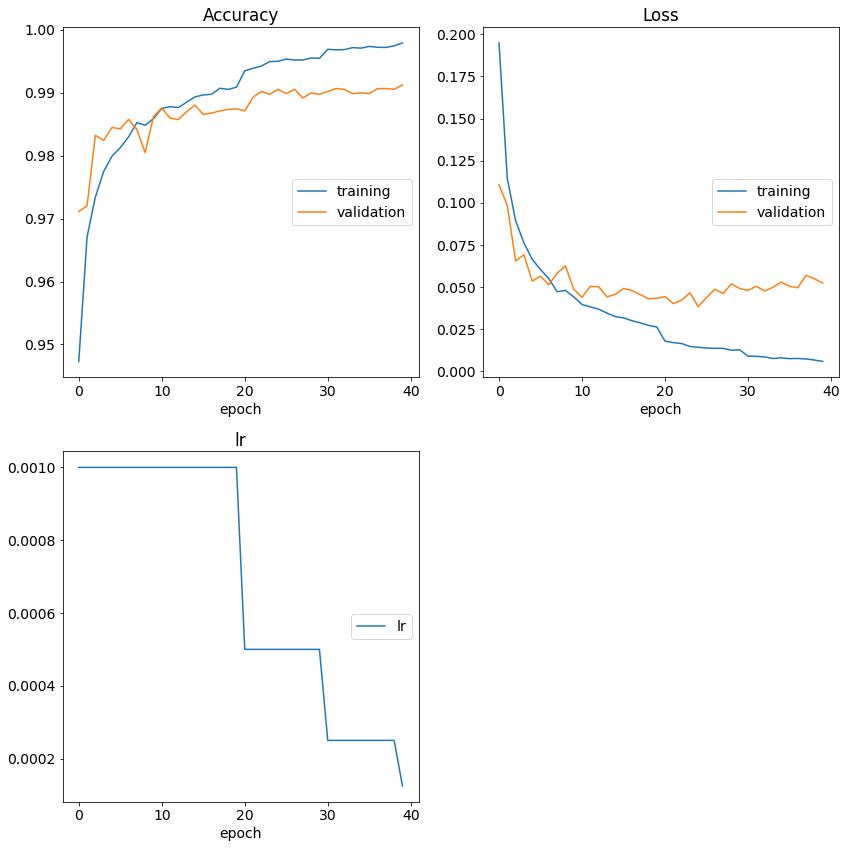

Accuracy
	training         	 (min:    0.947, max:    0.998, cur:    0.998)
	validation       	 (min:    0.971, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.006, max:    0.195, cur:    0.006)
	validation       	 (min:    0.038, max:    0.111, cur:    0.052)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
685/685 [==============================] - 2s 3ms/step - loss: 0.0756 - acc: 0.9888
Test accuracy: 98.88%


In [21]:
N_FILTS = [16, 32, 64] 

results = pd.DataFrame({'model':[], 'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[], 'lr':[], 'test_acc':[], 'test_f1':[]})
n1, n2, n3, kernel, drop = [5, 4, 0, 7, 0.3] 

for filt in N_FILTS:
    
    model_param = 'add_cnn_{}-{}-{}-ker{}-filt{}-drop{}'.format(n1,n2,n3,kernel,filt,drop)
    file_path = './models/' + model_param + '_mitbih.h5'
    
    print('*** currently at {} ***'.format(model_param))
    
    model = cnn_model(n1_cnn_layer = n1, n2_cnn_layer = n2, n3_dnn_layer = n3, n_filt = filt, kernel_size = kernel, dropout_rate = drop)
    history = run_add_cnn_experiment(model, [X,Y], [X_test, Y_test], skip_feats = None,
                                     weight_file_path=file_path, num_epochs=EPOCHS)
  
    model.load_weights(file_path) 

    pred_test = model.predict(X_test)
    pred_test = np.argmax(pred_test, axis=-1)

    f1_score_macro = f1_score(Y_test, pred_test, average='macro')
    acc_score = accuracy_score(Y_test, pred_test)

    model_results = pd.DataFrame(history.history)
    model_results['model'] = model_param
    model_results['test_acc'] = acc_score
    model_results['test_f1'] = f1_score_macro
    results = pd.concat([results, model_results], axis=0).reset_index(drop=True)
    
    results.to_csv('output/add_cnn_results.csv')

In [23]:
results = pd.read_csv('output/add_cnn_results.csv')

In [24]:
results[['val_acc','model']].groupby('model').max().sort_values(by='val_acc', ascending=False)[:10]

,val_acc
model,
add_cnn_5-4-0-ker7-filt64-drop0.3,0.991206
add_cnn_5-4-0-ker7-filt32-drop0.3,0.990635
add_cnn_5-4-0-ker7-filt16-drop0.3,0.989721


### Evaluate model

We select the model with the highest validation accuracy

f1 score micro:           0.98876
f1 score macro:           0.9331
accuracy score:           0.98876
balanced accuracy score:  0.92069


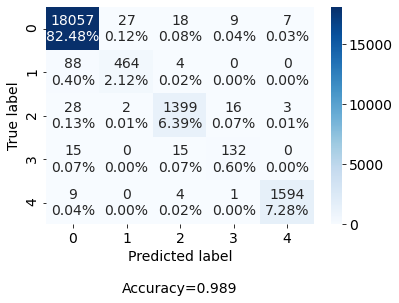

In [27]:
file_path ='./models/add_cnn_5-4-0-ker7-filt64-drop0.3_mitbih.h5'
model.load_weights(file_path) 

pred_test_proba = model.predict(X_test)
pred_test = np.argmax(pred_test_proba, axis=-1)

display_result(Y_test, pred_test)

### Store predictions

In [28]:
np.save("./predictions/test_mitbih_add_cnn", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_add_cnn", pred_test_proba, allow_pickle=True)

In [29]:
pred_train_proba = model.predict(X)
pred_train = np.argmax(pred_train_proba, axis=-1)

np.save("./predictions/train_mitbih_proba_add_cnn", pred_train_proba, allow_pickle=True)
np.save("./predictions/train_mitbih_add_cnn", pred_train, allow_pickle=True)

## Add Gaussian Noise Layer

We now add a Gaussian noise layer in order to try to increase the model's generalization capacity.

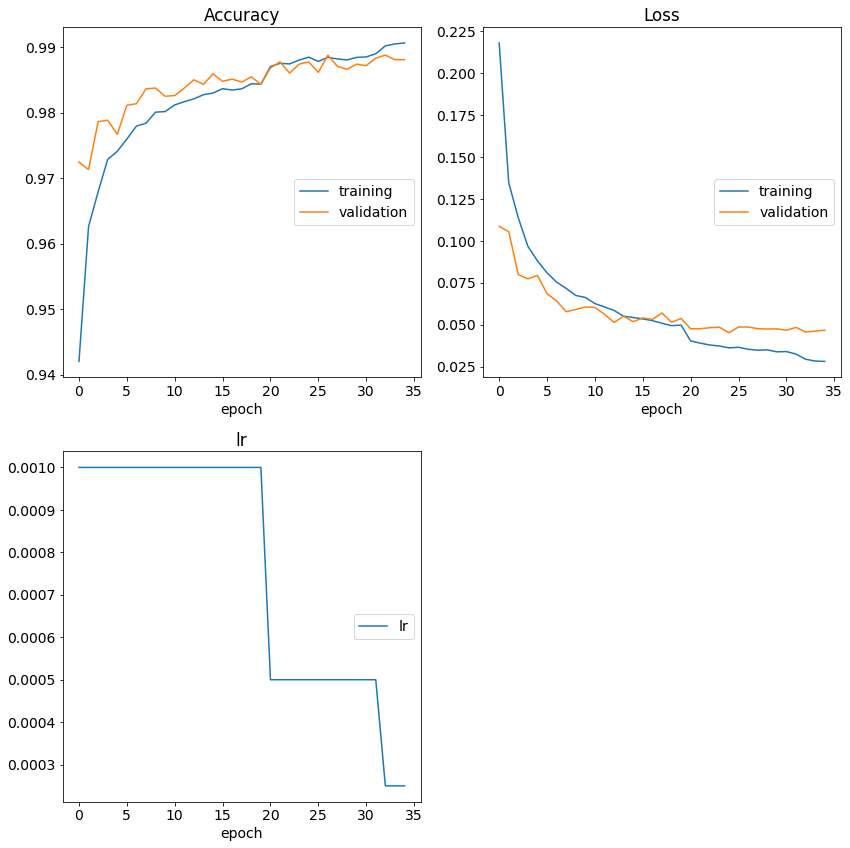

Accuracy
	training         	 (min:    0.942, max:    0.991, cur:    0.991)
	validation       	 (min:    0.971, max:    0.989, cur:    0.988)
Loss
	training         	 (min:    0.028, max:    0.218, cur:    0.028)
	validation       	 (min:    0.045, max:    0.109, cur:    0.047)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
2463/2463 [==============================] - 18s 7ms/step - loss: 0.0282 - acc: 0.9907 - val_loss: 0.0467 - val_acc: 0.9881
Epoch 00035: early stopping
685/685 [==============================] - 2s 3ms/step - loss: 0.0553 - acc: 0.9858
Test accuracy: 98.58%


In [31]:
file_path ='./models/add_cnn_gauss_mitbih.h5'

model = cnn_model(n1_cnn_layer = 5, n2_cnn_layer = 4, n3_dnn_layer = 0, 
                  n_filt = 64, kernel_size = 7, dropout_rate = 0.3,
                  Gaussian_noise=True, stddev=0.05
                 )

history = run_add_cnn_experiment(model, [X,Y], [X_test, Y_test], skip_feats = None,
                                 weight_file_path=file_path, num_epochs=EPOCHS)    

We observe from the validation loss curve that the model with the Gaussian layer does not overfit as quickly to the training data as without it. This is to be expected by introducing noise when training.

### Evaluate model

f1 score micro:           0.98584
f1 score macro:           0.91787
accuracy score:           0.98584
balanced accuracy score:  0.90054


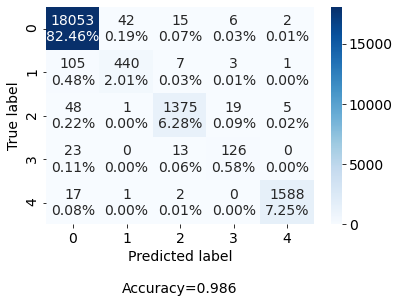

In [32]:
file_path ='./models/add_cnn_gauss_mitbih.h5'
model.load_weights(file_path) 

pred_test_proba = model.predict(X_test)
pred_test = np.argmax(pred_test_proba, axis=-1)

display_result(Y_test, pred_test)

Despite not overfitting as quickly as the first model without Gaussian layer, it has lower scores on the test set. That is, the extra noise had a detrimental effect for these particular datasets.

### Store predictions

In [33]:
np.save("./predictions/test_mitbih_gauss_cnn", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_gauss_cnn", pred_test_proba, allow_pickle=True)

In [34]:
pred_train_proba = model.predict(X)
pred_train = np.argmax(pred_train_proba, axis=-1)

np.save("./predictions/train_mitbih_proba_gauss_cnn", pred_train_proba, allow_pickle=True)
np.save("./predictions/train_mitbih_gauss_cnn", pred_train, allow_pickle=True)

## Add Residual Layer

We know extract time series features from the heartbeats. These additional features will be integrated into the network via a residual (skip) connection.

In [35]:
SAMPLING_RATE = 125.0

**Warning** Extracting the features does take quite some time.

In [36]:
if False: # to initially extract the features, set this to True

    # temporary reshaped datasets
    X2 = X.reshape(X.shape[0], X.shape[1])
    X2_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

    X_train_spec_f, X_test_spec_f = get_tsfel_features(X2, X2_test, domain="spectral", njobs=32, sampling_rate=SAMPLING_RATE) 
    X_train_stat_f, X_test_stat_f = get_tsfel_features(X2, X2_test, domain="statistical", njobs=32, sampling_rate=SAMPLING_RATE) 
    X_train_temp_f, X_test_temp_f = get_tsfel_features(X2, X2_test, domain="temporal", njobs=32, sampling_rate=SAMPLING_RATE) 

    # delete temporary datasets
    del(X2)
    del(X2_test)

    # save extracted features for later usage
    X_train_spec_f.to_csv('./output/spectral_feats_train.csv', index=False)
    X_test_spec_f.to_csv('./output/spectral_feats_test.csv', index=False)
    X_train_stat_f.to_csv('./output/statistical_feats_train.csv', index=False)
    X_test_stat_f.to_csv('./output/statistical_feats_test.csv', index=False)
    X_train_temp_f.to_csv('./output/temporal_feats_train.csv', index=False)
    X_test_temp_f.to_csv('./output/temporal_feats_test.csv', index=False)

else:
    X_train_spec_f = pd.read_csv('./output/spectral_feats_train.csv')
    X_test_spec_f = pd.read_csv('./output/spectral_feats_test.csv')
    X_train_stat_f = pd.read_csv('./output/statistical_feats_train.csv')
    X_test_stat_f = pd.read_csv('./output/statistical_feats_test.csv')
    X_train_temp_f = pd.read_csv('./output/temporal_feats_train.csv')
    X_test_temp_f = pd.read_csv('./output/temporal_feats_test.csv')

#### Use spectral features only for residual connection

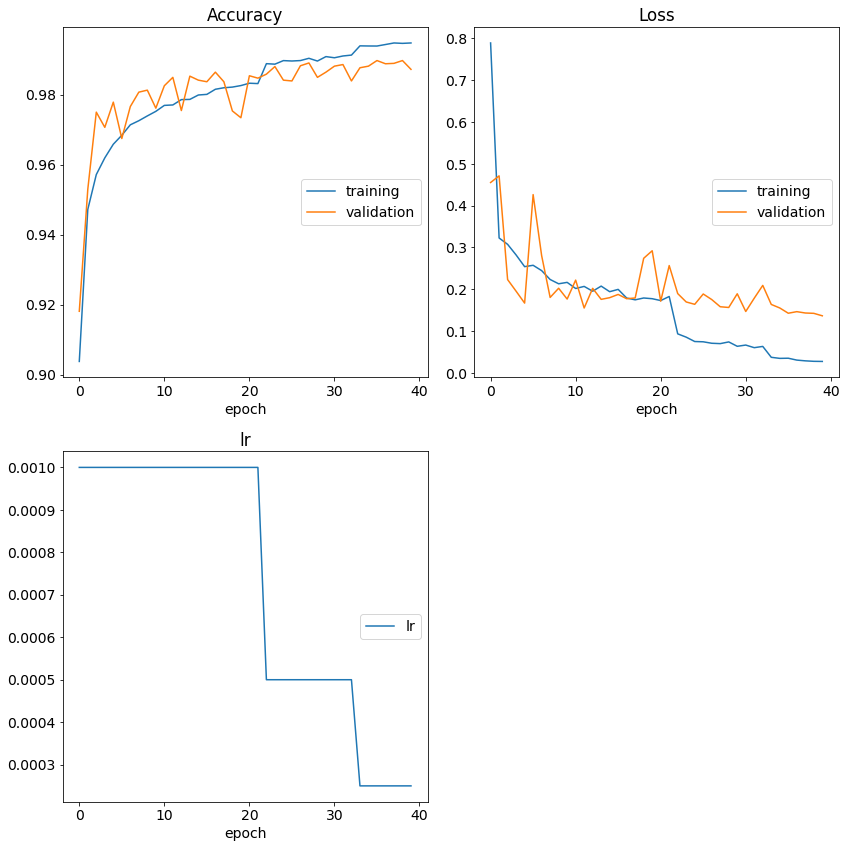

Accuracy
	training         	 (min:    0.904, max:    0.995, cur:    0.995)
	validation       	 (min:    0.918, max:    0.990, cur:    0.987)
Loss
	training         	 (min:    0.027, max:    0.789, cur:    0.027)
	validation       	 (min:    0.137, max:    0.471, cur:    0.137)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
685/685 [==============================] - 2s 3ms/step - loss: 0.1992 - acc: 0.9864
Test accuracy: 98.64%


In [37]:
file_path ='./models/add_cnn_res_spec_mitbih.h5'

model = cnn_model(n1_cnn_layer = 5, n2_cnn_layer = 4, n3_dnn_layer = 0, 
                  n_filt = 64, kernel_size = 7, dropout_rate = 0.3,
                  Gaussian_noise=False, stddev=None,
                  skip_feats_dim = X_train_spec_f.shape[1]
                 )

history = run_add_cnn_experiment(model, [X,Y], [X_test, Y_test], skip_feats = [X_train_spec_f, X_test_spec_f],
                                 weight_file_path=file_path, num_epochs=EPOCHS)    

### Evaluate model

f1 score micro:           0.98643
f1 score macro:           0.91848
accuracy score:           0.98643
balanced accuracy score:  0.91057


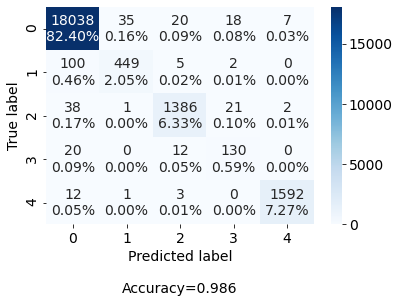

In [38]:
model.load_weights(file_path) 

pred_test_proba = model.predict([X_test, X_test_spec_f])
pred_test = np.argmax(pred_test_proba, axis=-1)

display_result(Y_test, pred_test)

Residual connection with spectral features did not improve the score. 

### Store predictions

In [40]:
np.save("./predictions/test_mitbih_res_spec_cnn", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_res_spec_cnn", pred_test_proba, allow_pickle=True)

In [41]:
pred_train_proba = model.predict([X, X_train_spec_f])
pred_train = np.argmax(pred_train_proba, axis=-1)

np.save("./predictions/train_mitbih_proba_res_spec_cnn", pred_train_proba, allow_pickle=True)
np.save("./predictions/train_mitbih_res_spec_cnn", pred_train, allow_pickle=True)

#### Use all extracted features for residual connection

In [42]:
X_train_all_f = pd.concat([X_train_spec_f, X_train_stat_f, X_train_temp_f], axis=1)
X_test_all_f = pd.concat([X_test_spec_f, X_test_stat_f, X_test_temp_f], axis=1)

In [ ]:
file_path ='./models/add_cnn_res_all_mitbih.h5'

model = cnn_model(n1_cnn_layer = 5, n2_cnn_layer = 4, n3_dnn_layer = 0, 
                  n_filt = 64, kernel_size = 7, dropout_rate = 0.3,
                  Gaussian_noise=False, stddev=None,
                  skip_feats_dim = X_train_all_f.shape[1]
                 )

history = run_add_cnn_experiment(model, [X,Y], [X_test, Y_test], skip_feats = [X_train_all_f, X_test_all_f],
                                 weight_file_path=file_path, num_epochs=EPOCHS)    

### Evaluate model

f1 score micro:           0.98616
f1 score macro:           0.91803
accuracy score:           0.98616
balanced accuracy score:  0.90395


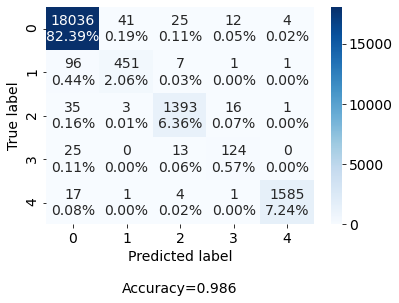

In [44]:
model.load_weights(file_path) 

pred_test_proba = model.predict([X_test, X_test_all_f])
pred_test = np.argmax(pred_test_proba, axis=-1)

display_result(Y_test, pred_test)

Balanced Accuracy slightly better than with spectral features only. But overall still worse than without a residual connection.

### Store predictions

In [45]:
np.save("./predictions/test_mitbih_res_all_cnn", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_res_all_cnn", pred_test_proba, allow_pickle=True)

In [46]:
pred_train_proba = model.predict([X, X_train_all_f])
pred_train = np.argmax(pred_train_proba, axis=-1)

np.save("./predictions/train_mitbih_proba_res_all_cnn", pred_train_proba, allow_pickle=True)
np.save("./predictions/train_mitbih_res_all_cnn", pred_train, allow_pickle=True)

# PTBDB Model

We will restrict ourselves to the model without any skip connection or Gaussian layer as it performed best for the MITBIH dataset above.

## Load data

In [5]:
df_1_ptb = pd.read_csv("./data/ptbdb_normal.csv", header=None)
df_2_ptb = pd.read_csv("./data/ptbdb_abnormal.csv", header=None)
df_ptb = pd.concat([df_1_ptb, df_2_ptb])

df_train_ptb, df_test_ptb = train_test_split(df_ptb, test_size=0.2, random_state=1337, stratify=df_ptb[187])


Y_ptb = np.array(df_train_ptb[187].values).astype(np.int8)
X_ptb = np.array(df_train_ptb[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test_ptb[187].values).astype(np.int8)
X_test_ptb = np.array(df_test_ptb[list(range(187))].values)[..., np.newaxis]

## Training

In [18]:
EPOCHS = 100 # Due to faster training time, we increase number of epochs

In [19]:
TRANSFER = True # configure to use transfer learning or not 

When transfer learning we initialize the weights with the pretrained ones from the MITBIH dataset, train the complete network on the new data and use learning rate scheduling, early stopping to prevent overfitting

In [20]:
# we will later change to a binary classification head instead of 5 classes
model_ptb_raw = cnn_model(n1_cnn_layer = 5, n2_cnn_layer = 4, n3_dnn_layer = 0, 
                  n_filt = 64, kernel_size = 7, dropout_rate = 0.3,
                  Gaussian_noise=False, stddev=None
                 )

In [21]:
opt_ptb = optimizers.Adam(0.001)
model_ptb_raw.compile(optimizer=opt_ptb, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])

In [22]:
# Load weights from MITBIH for transfer learning (comment out if training purely)
if TRANSFER:
    print("Loading pretrained weights from MITBIH dataset")
    file_path ='./models/add_cnn_5-4-0-ker7-filt64-drop0.3_mitbih.h5'
    model_ptb_raw.load_weights(file_path)

transfer_str = "_transfer" if TRANSFER else "" 

Loading pretrained weights from MITBIH dataset


### Reconfigure model

Reconfigure the model to have binary classification head instead of 5 classes

In [23]:
new_out = Dense(1, activation=activations.sigmoid, name="ptb_sigmoid")(model_ptb_raw.layers[-2].output)

model_ptb = Model(inputs=model_ptb_raw.input, outputs=new_out)
model_ptb.compile(optimizer=opt_ptb, loss=losses.BinaryCrossentropy(), metrics=['acc'])

### Fitting

In [24]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 
reduce_lr_factor = 0.5     
patience         = 5
cooldown         = 5 

weight_file_path_ptb = f"./models/add_cnn_ptb{transfer_str}.h5"
checkpoint = ModelCheckpoint(weight_file_path_ptb, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat] 

In [ ]:
 model_ptb.fit(
    X_ptb, Y_ptb, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, 
    callbacks=callbacks_list,  
    validation_split=0.1,
    shuffle=True,
)

### Evaluation

f1 score micro:           0.99553
f1 score macro:           0.99443
accuracy score:           0.99553
balanced accuracy score:  0.99425
AuPR score:               0.99906
AuROC score:              0.99861


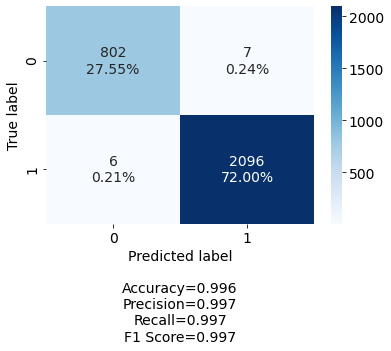

In [26]:
# load best weights
model_ptb.load_weights(weight_file_path_ptb) 

pred_test_proba = model_ptb.predict(X_test_ptb)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]

display_result(Y_test_ptb, pred_test, curve=True, proba=pred_test_proba)

### Store predictions

In [27]:
transfer_str = "_transfer" if TRANSFER else "" 

In [28]:
np.save(f"./predictions/test_ptb_add_cnn{transfer_str}", pred_test, allow_pickle=True)
np.save(f"./predictions/test_ptb_proba_add_cnn{transfer_str}", pred_test_proba, allow_pickle=True)

In [29]:
pred_train_proba = model_ptb.predict(X_ptb)
pred_train = [1 if x > 0.5 else 0 for x in pred_train_proba]
np.save(f"./predictions/train_ptb_add_cnn{transfer_str}", pred_train, allow_pickle=True)
np.save(f"./predictions/train_ptb_proba_add_cnn{transfer_str}", pred_train_proba, allow_pickle=True)